# Visualización de conjuntos de datos de Stanford y Santa Maria
Roberto Araya Day

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import os
from PIL import Image
from scipy.ndimage import zoom

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    return slice.clip(min,max)


def map_fun(image, label) :    
    
    #TODO 
    crop_size = 256    
    image = (image - min_val)/ val_range
    image = tf.image.grayscale_to_rgb(image)
    size = int(crop_size * 1.15)
    image = tf.image.resize_with_pad(image, size, size)
    image = tf.image.random_crop(image, (crop_size, crop_size,3))
    image = tf.image.random_flip_left_right(image)
    label =  tf.one_hot(label, 2)
    return image, label


def extract_roi(image, mask, margin, min_val):
    # Convert mask to boolean tensor
    mask = tf.cast(mask, dtype=tf.bool)

    # Find indices where mask equals 1
    indices = tf.where(mask)
    
    #image = tf.where(mask, image, min_val)

    # Get the minimum and maximum indices along each axis
    min_row = tf.reduce_min(indices[:, 0])
    min_col = tf.reduce_min(indices[:, 1])
    max_row = tf.reduce_max(indices[:, 0])
    max_col = tf.reduce_max(indices[:, 1])

    # Extract the bounding box from the image
    bounding_box = image[min_row-margin:max_row + 1+margin, min_col-margin:max_col + 1+margin]

    return bounding_box

## Visualizar ejemplos multimodales

In [26]:
max_val = 1000
min_val = -1000
val_range = max_val - min_val
padding = 4
size = 256

def visualize_n_samples(n_patients, n_samples, body_ds, body_info, torax_ds, torax_info, pet_ds, pet_info, show_slice_fn=True, padding=1):
    # Obtener las claves de los conjuntos de datos para cada modalidad
    body_keys, torax_keys, pet_keys = list(body_info.splits.keys()), list(torax_info.splits.keys()), list(pet_info.splits.keys())

    # Inicializar contadores
    patients_counter = 0

    # Iterar sobre las claves comunes a los tres conjuntos de datos
    for key in set(body_keys) & set(torax_keys) & set(pet_keys):
        patients_counter += 1
        # Obtener datos para cada modalidad del paciente actual
        body_data, torax_data, pet_data = body_ds[key], torax_ds[key], pet_ds[key]
        print("patient:", key)

        # Inicializar el contador de muestras
        samples_counter = 0

        # Iterar sobre las muestras de cada modalidad
        for body_sample, torax_sample, pet_sample in zip(body_data, torax_data, pet_data):
            samples_counter += 1

            # Crear una figura con subgráficos
            f, axarr = plt.subplots(2, 3, figsize=(10, 7))
            
            # Iterar sobre las modalidades y mostrar las imágenes y máscaras
            modalities = ["Body Exam", "Torax 3D Exam", "Pet Exam"]
            for i, (sample, title) in enumerate(zip([body_sample, torax_sample, pet_sample], modalities)):
                label = sample['egfr_label']
                
                print("space dimensions ", sample['exam_metadata']['space_directions'].numpy(), sample['exam_metadata']['space_origin'].numpy())

                if title == "Pet Exam": print("liver roi mean: ", tf.reduce_mean(sample['pet_liver']))
                axarr[0, i].set_title(f"{title} - Label {label}")
                cmap = 'gray_r' if sample is pet_sample else 'gray'
                axarr[0, i].imshow(sample['img_exam'], cmap=cmap)
                axarr[0, i].imshow(sample['mask_exam'], cmap='gnuplot', alpha=0.4)

            # Iterar sobre las modalidades y mostrar las imágenes con la máscara de la región de interés (ROI)
            for i, (sample, title) in enumerate(zip([body_sample, torax_sample, pet_sample], modalities)):
                label = sample['egfr_label']
                axarr[1, i].set_title(f"{title} ROI Mask")

                #img_exam = tf.where(sample['img_exam'] < min_val, min_val, sample['img_exam'])
                #img_exam = tf.where(sample['img_exam'] > max_val, max_val, sample['img_exam'])
                img_exam = sample['img_exam']
                
                data_roi = extract_roi(img_exam, sample['mask_exam'], margin = padding, min_val=min_val)  
                
                #print('{} {} {}'.format(np.min(data_roi), np.max(data_roi), data_roi.shape))
                data_roi = tf.expand_dims(data_roi, -1)
                imm = tf.image.resize(data_roi, (size, size))
        
                #if (sample is body_sample or sample is torax_sample) and show_slice_fn: imm = show_slice_window(imm, 70, 140)
                cmap = 'gray_r' if sample is pet_sample else 'gray'
                axarr[1, i].imshow(imm, cmap=cmap)
            
            # Mostrar la figura con subgráficos
            plt.show()

            # Romper el bucle si se alcanza el número deseado de muestras
            if samples_counter >= n_samples:
                break
        
        # Romper el bucle si se alcanza el número deseado de pacientes
        if patients_counter >= n_patients:
            break

Santa Maria dataset label classnames:  ['Wildtype', 'Mutant']
patient: sm_032
space dimensions  [0.98632812 0.98632812 2.99999977] [ -247.801466  -163.746416 -1135.49995 ]
space dimensions  [0.98632812 0.98632812 1.        ] [-247.8014679  -163.74641418 -725.5       ]
space dimensions  [4. 4. 4.] [ -286.5859375   -216.5859375  -1234.80004883]
liver roi mean:  tf.Tensor(1.0588328, shape=(), dtype=float32)


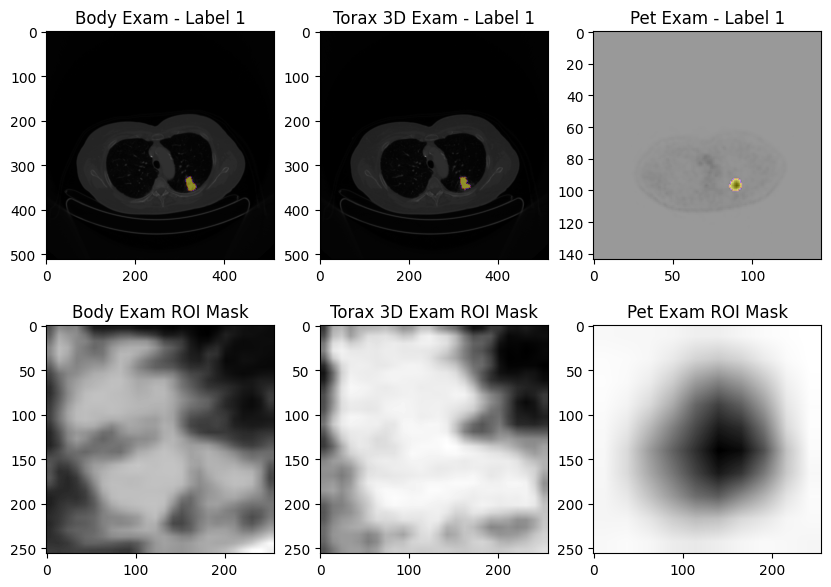

patient: sm_018
space dimensions  [1.015625 1.015625 3.      ] [ -260.   -190.  -1446.5]
space dimensions  [0.86328125 0.86328125 0.70007324] [-235.         -106.79999542 -883.40002441]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1447.5      ]
liver roi mean:  tf.Tensor(0.70364153, shape=(), dtype=float32)


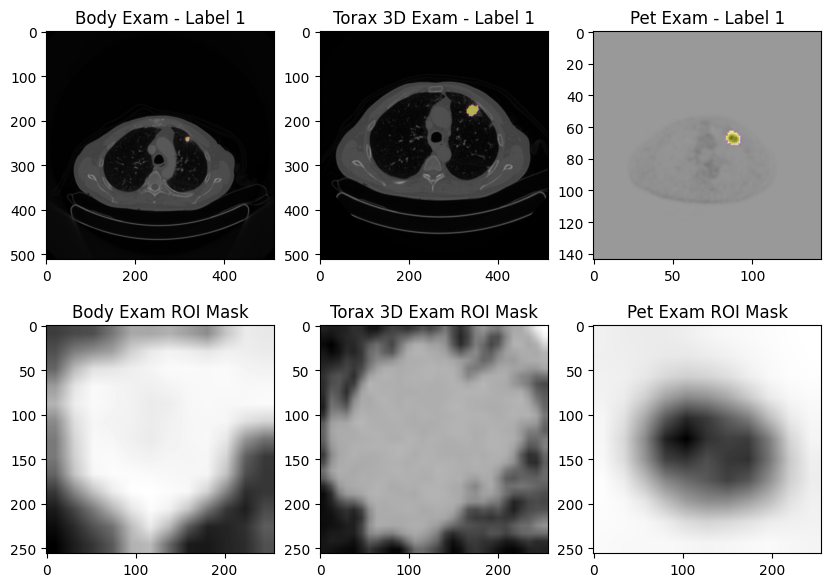

patient: sm_001
space dimensions  [1.019531 1.019531 1.25    ] [ -261.  -261. -1042.]
space dimensions  [1.019531 1.019531 1.25    ] [ -261.  -261. -1042.]
space dimensions  [3.64583325 3.64583325 3.27001953] [ -348.17709351  -348.17709351 -1032.56506348]
liver roi mean:  tf.Tensor(0.5160898, shape=(), dtype=float32)


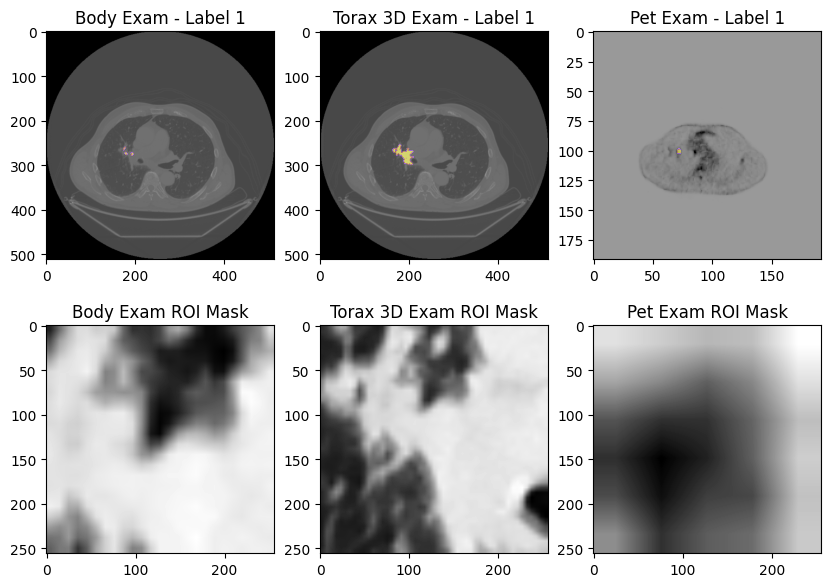

patient: sm_031
space dimensions  [1.015625 1.015625 3.      ] [ -260.   -190.  -1372.5]
space dimensions  [0.83789062 0.83789062 0.69995117] [-221.5        -144.5        -758.09997559]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1373.5      ]
liver roi mean:  tf.Tensor(0.7103283, shape=(), dtype=float32)


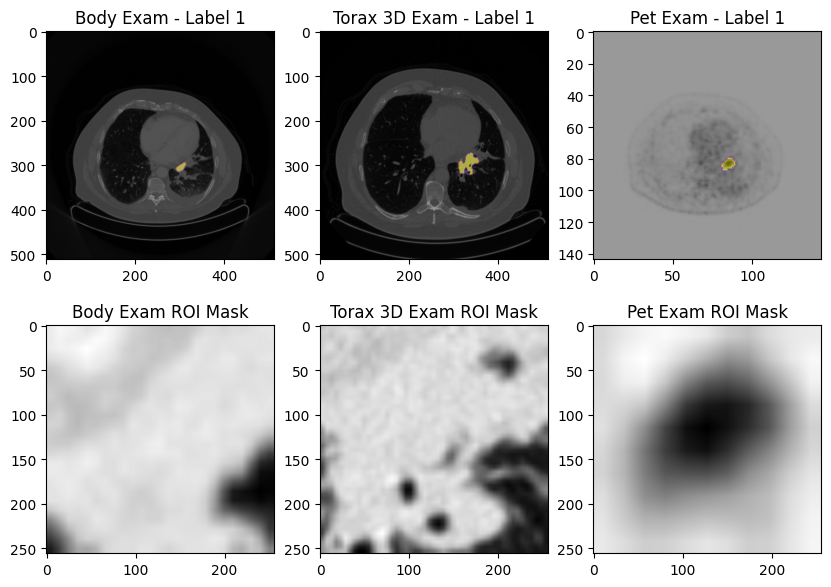

patient: sm_002
space dimensions  [0.99804688 0.99804688 3.        ] [ -255.5  -185.5 -1310.5]
space dimensions  [0.79492188 0.79492188 0.70001221] [-214.35263062 -105.65263367 -870.29998779]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1311.5      ]
liver roi mean:  tf.Tensor(0.8049663, shape=(), dtype=float32)


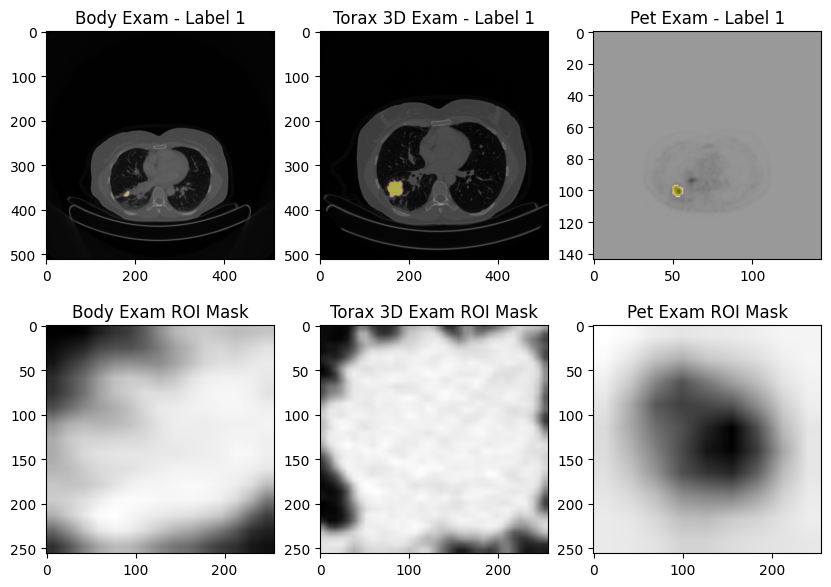

patient: sm_017
space dimensions  [1.02539062 1.02539062 3.        ] [ -262.5  -192.5 -1515.5]
space dimensions  [0.79882812 0.79882812 0.70001221] [-199.5        -112.97368622 -748.79998779]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1516.5      ]
liver roi mean:  tf.Tensor(0.77606654, shape=(), dtype=float32)


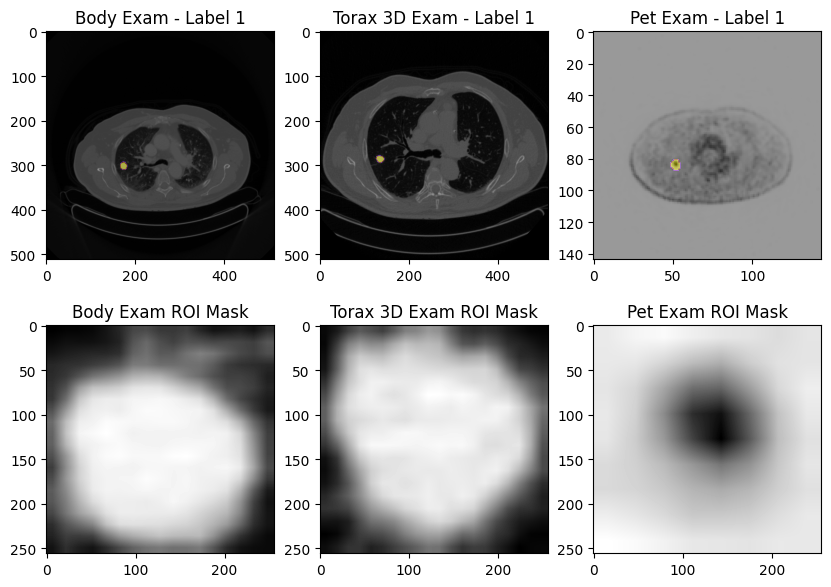

patient: sm_007
space dimensions  [0.98046875 0.98046875 3.        ] [ -251.   -181.  -1393.5]
space dimensions  [0.78710938 0.78710938 0.70007324] [-189.74211121  -95.44210052 -838.40002441]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1394.5      ]
liver roi mean:  tf.Tensor(0.8625658, shape=(), dtype=float32)


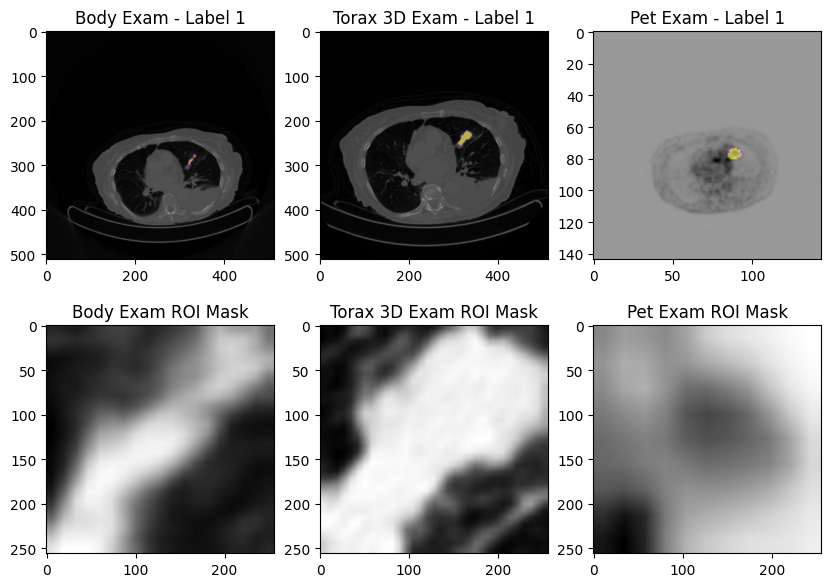

patient: sm_004
space dimensions  [1.03515625 1.03515625 3.        ] [ -265.   -195.  -1401.5]
space dimensions  [0.7890625  0.7890625  0.69995117] [-213.87368774  -72.46316528 -778.59997559]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1402.5      ]
liver roi mean:  tf.Tensor(0.74537426, shape=(), dtype=float32)


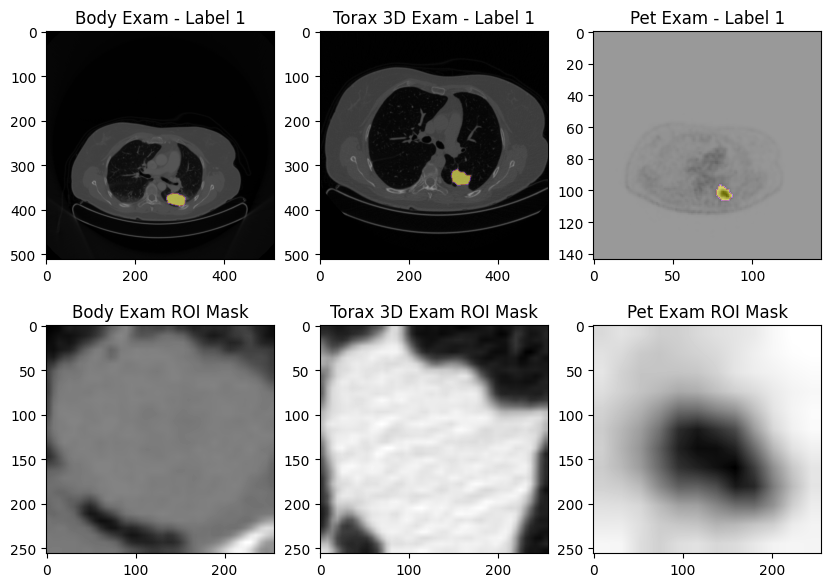

patient: sm_012
space dimensions  [0.97070312 0.97070312 3.        ] [ -248.5  -178.5 -1649.5]
space dimensions  [0.81054688 0.81054688 0.70007324] [-196.13157654 -122.21052551 -815.40002441]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1650.5      ]
liver roi mean:  tf.Tensor(0.5631807, shape=(), dtype=float32)


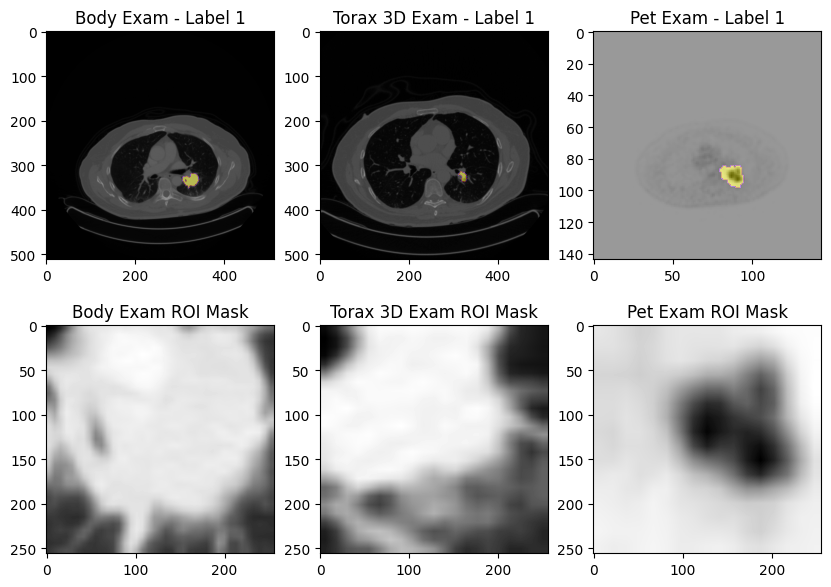

patient: sm_034
space dimensions  [1.03125 1.03125 3.     ] [ -264.   -195.  -1268.5]
space dimensions  [1.171875 1.171875 3.      ] [-300.  -230.  -844.5]
space dimensions  [4. 4. 4.] [-286.5859375 -216.5859375 -845.5      ]
liver roi mean:  tf.Tensor(2.6610043, shape=(), dtype=float32)


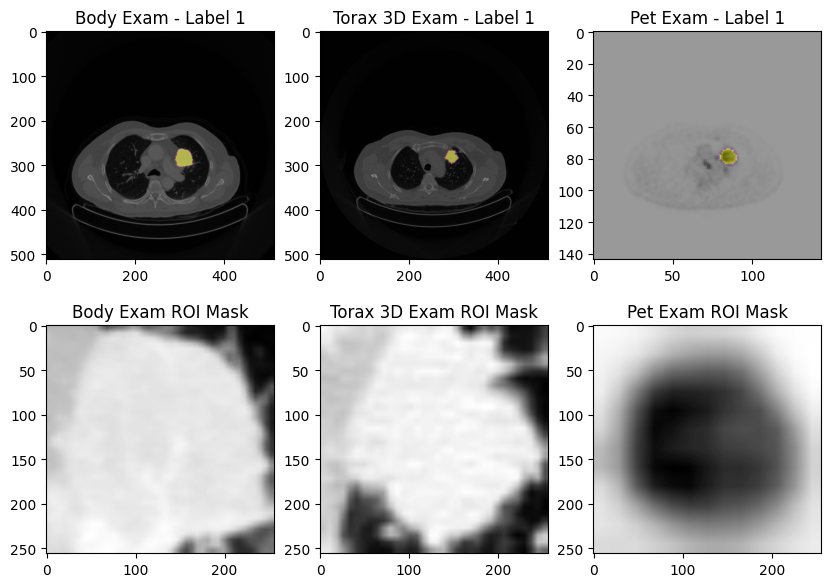

In [27]:
# se cargan los conjuntos de datos de santa maria
# incluir spacing en santamaria_info
santamaria_body_dataset, santamaria_body_info = tfds.load('santa_maria_dataset/body', with_info=True)
santamaria_torax_dataset, santamaria_torax_info = tfds.load('santa_maria_dataset/torax3d', with_info=True)
santamaria_pet_dataset, santamaria_pet_info = tfds.load('santa_maria_dataset/pet', with_info=True)

print("Santa Maria dataset label classnames: ", santamaria_body_info.features['egfr_label'].names)

# cantidad de pacientes a mostrar, cantidad de ejemplos y función de extraccion de ROI
n_patients = 10
n_samples = 1

visualize_n_samples(n_patients, n_samples, 
                    santamaria_body_dataset, santamaria_body_info, santamaria_torax_dataset, 
                     santamaria_torax_info, santamaria_pet_dataset, santamaria_pet_info)

Stanford dataset label classnames:  ['Wildtype', 'Mutant', 'Unknown', 'Not collected']
patient: AMC-011
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -882.99]
space dimensions  [0.84179688 0.84179688 1.        ] [-200.07910156 -392.03910156 -399.        ]
space dimensions  [3.64583325 3.64583325 3.26999996] [-348.17709351 -348.17709351 -882.98999023]
liver roi mean:  tf.Tensor(0.40950757, shape=(), dtype=float32)


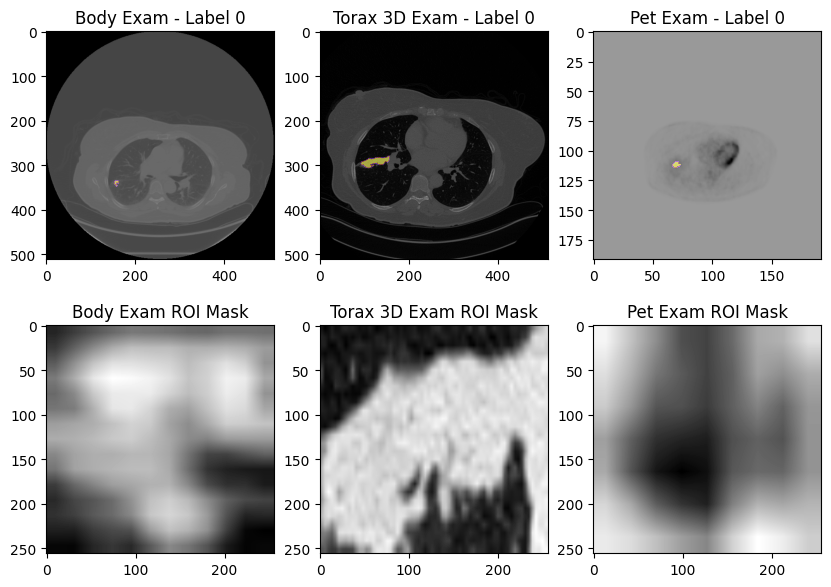

patient: R01-132
space dimensions  [0.9765625 0.9765625 4.       ] [-249.51171875 -439.51171875  442.        ]
space dimensions  [0.703125 0.703125 2.5     ] [-196.6   -180.    -324.125]
space dimensions  [4.07283 4.07283 4.     ] [-342.0726969  -530.33507001  442.        ]
liver roi mean:  tf.Tensor(2.195012, shape=(), dtype=float32)


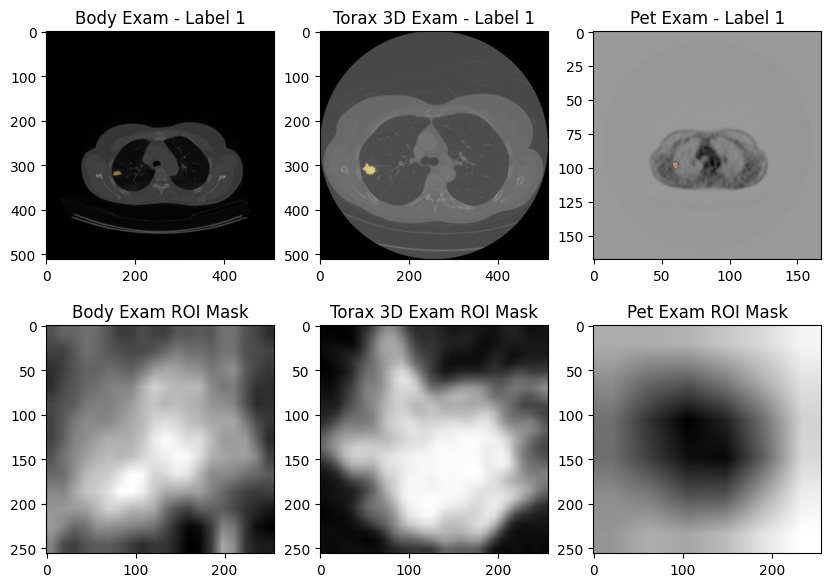

patient: R01-114
space dimensions  [1.367188 1.367188 3.27    ] [-350.   -350.   -917.22]
space dimensions  [0.976562 0.976562 1.25    ] [-244.3 -250.  -283.5]
space dimensions  [5.46875    5.46875    3.27000006] [-347.265625   -347.265625   -917.20001221]
liver roi mean:  tf.Tensor(0.7335759, shape=(), dtype=float32)


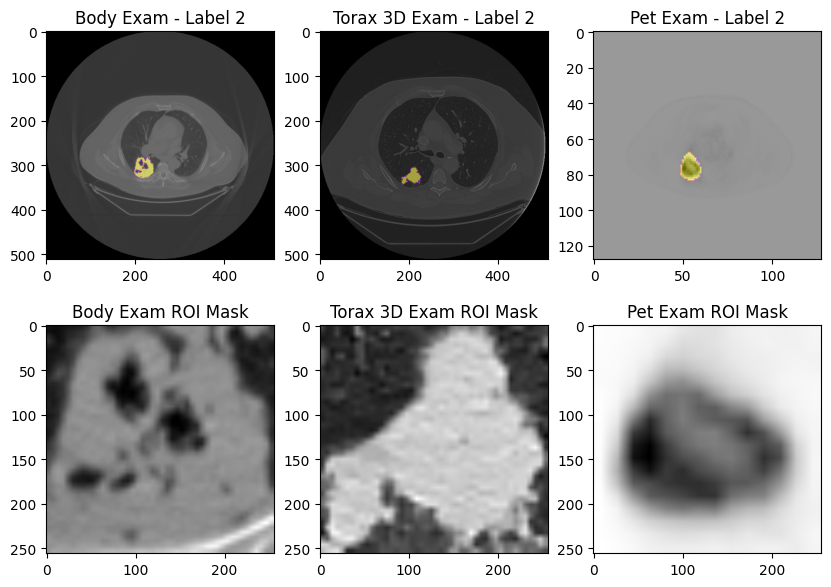

patient: AMC-012
space dimensions  [0.87890625 0.87890625 5.        ] [-225. -155. -958.]
space dimensions  [0.60742188 0.60742188 0.80000006] [-137.5        14.5       832.799957]
space dimensions  [4.         4.         3.99999993] [-286.585938 -216.585938 -949.174988]
liver roi mean:  tf.Tensor(0.5321468, shape=(), dtype=float32)


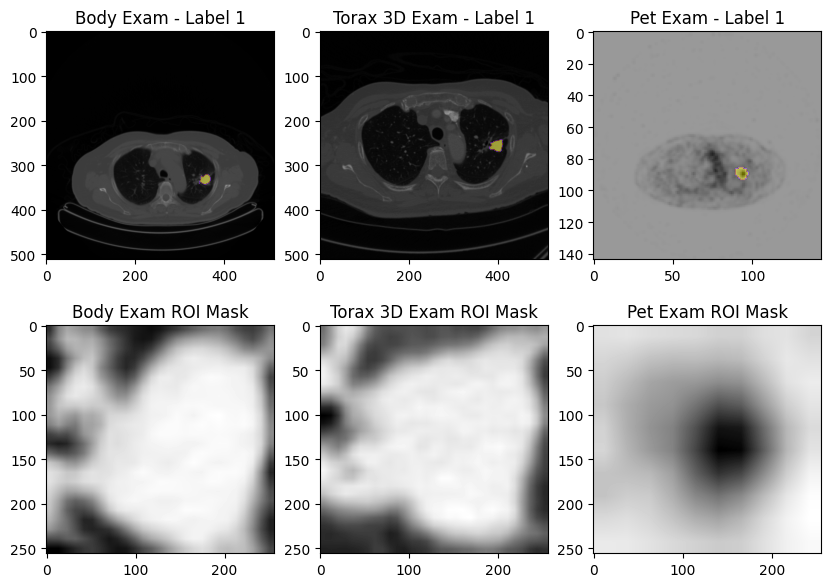

patient: R01-096
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -804.42]
space dimensions  [0.78125 0.78125 1.25   ] [-200. -200. -300.]
space dimensions  [5.46875    5.46875    3.27000012] [-347.265625   -347.265625   -804.40002441]
liver roi mean:  tf.Tensor(0.9536682, shape=(), dtype=float32)


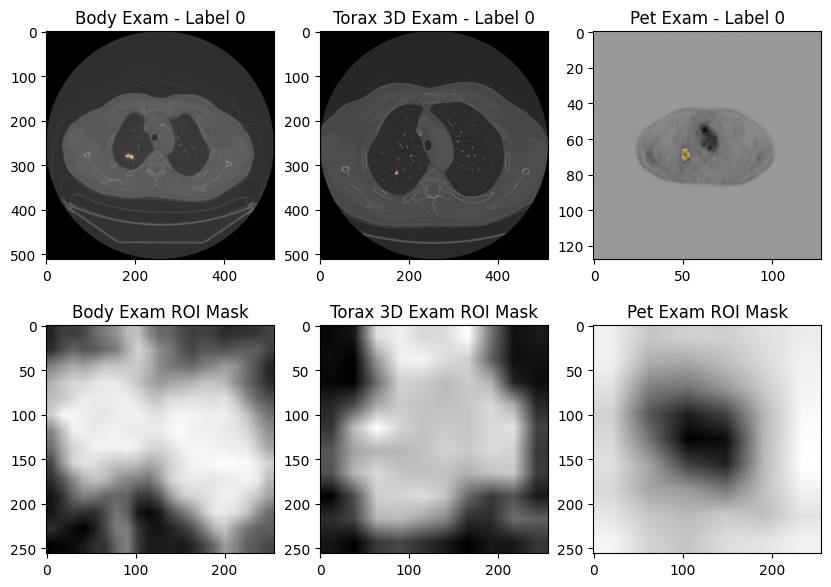

patient: AMC-021
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -853.24]
space dimensions  [0.61132812 0.61132812 1.        ] [-150.19433594 -315.19433594 -348.        ]
space dimensions  [3.64583325 3.64583325 3.26999997] [-348.17709351 -348.17709351 -853.23999023]
liver roi mean:  tf.Tensor(1.2055082, shape=(), dtype=float32)


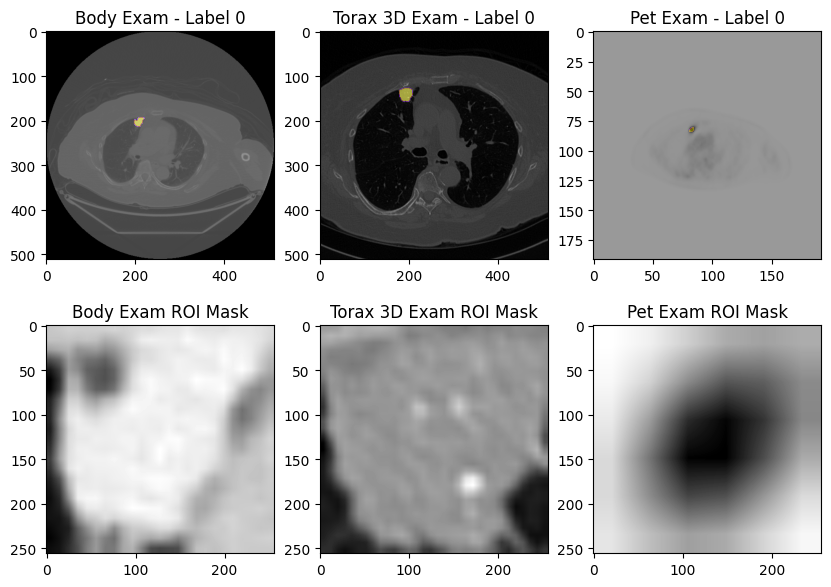

patient: R01-047
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -814.62]
space dimensions  [0.78125 0.78125 1.25   ] [-200.  -191.2 -219. ]
space dimensions  [5.46875    5.46875    3.26999989] [-347.265625   -347.265625   -814.59997559]
liver roi mean:  tf.Tensor(0.6560666, shape=(), dtype=float32)


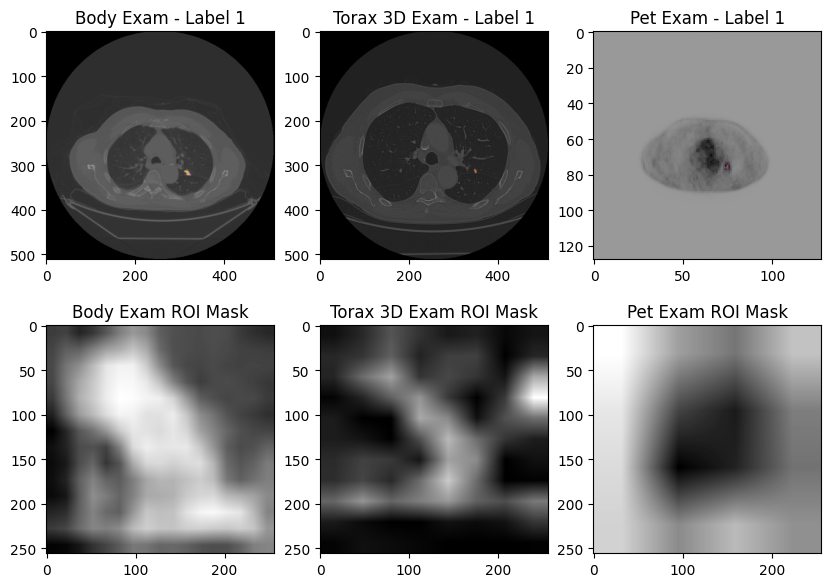

patient: AMC-020
space dimensions  [1.367188 1.367188 3.27    ] [-350.   -350.   -868.99]
space dimensions  [0.828125 0.828125 1.      ] [-201.5859375 -355.0859375 -314.       ]
space dimensions  [3.64583325 3.64583325 3.26999997] [-348.17709351 -348.17709351 -868.98999023]
liver roi mean:  tf.Tensor(1.0638646, shape=(), dtype=float32)


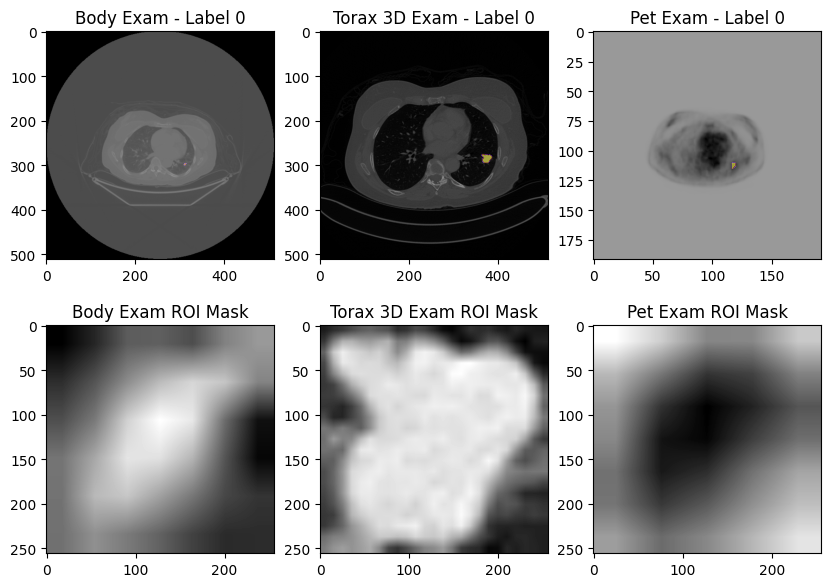

patient: R01-136
space dimensions  [0.9765625 0.9765625 4.       ] [-249.51171875 -403.51171875 -902.5       ]
space dimensions  [0.62109375 0.62109375 2.5       ] [-165.68945312 -292.18945312  -14.3       ]
space dimensions  [4.07283 4.07283 3.     ] [-341.76763701 -497.58867001 -901.5       ]
liver roi mean:  tf.Tensor(1.1083989, shape=(), dtype=float32)


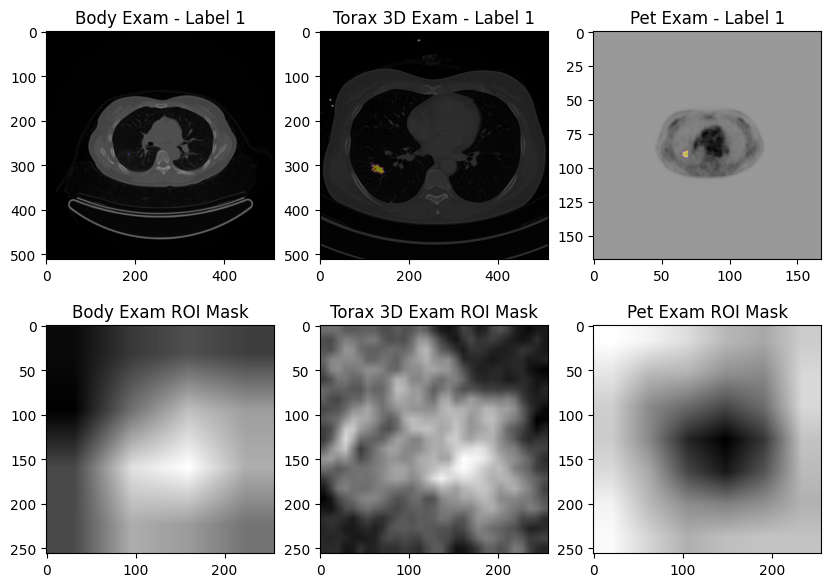

patient: R01-068
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -990.96]
space dimensions  [0.804688 0.804688 1.25    ] [-222.   -206.   -322.75]
space dimensions  [5.46875    5.46875    3.26986577] [-347.265625 -347.265625 -991.      ]
liver roi mean:  tf.Tensor(0.5919872, shape=(), dtype=float32)


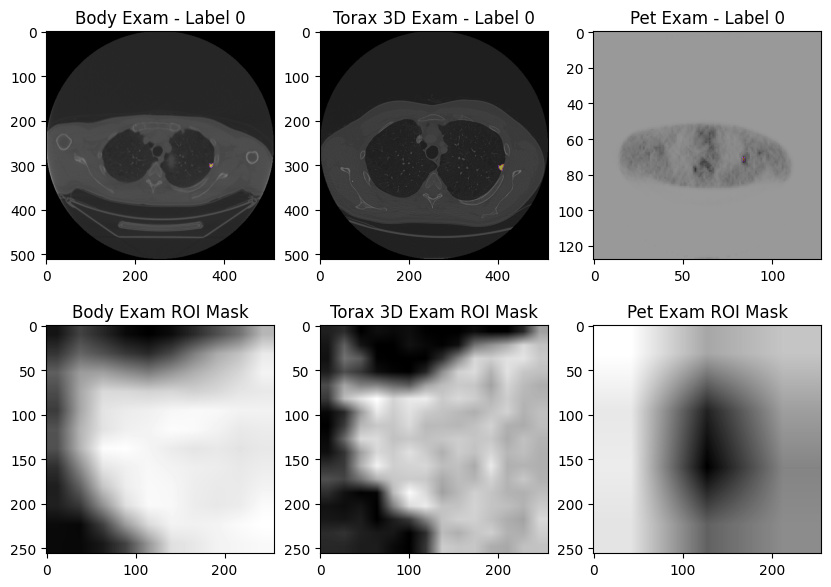

In [29]:
# se cargan los conjuntos de datos de santa maria
stanford_body_dataset, stanford_body_info = tfds.load('stanford_dataset/ct', with_info=True)
stanford_torax_dataset, stanford_torax_info = tfds.load('stanford_dataset/chest_ct', with_info=True)
stanford_pet_dataset, stanford_pet_info = tfds.load('stanford_dataset/pet', with_info=True)

print("Stanford dataset label classnames: ", stanford_body_info.features['egfr_label'].names)

# cantidad de pacientes a mostrar, cantidad de ejemplos y función de extraccion de ROI
n_patients = 10
n_samples = 1

visualize_n_samples(n_patients, n_samples,
                    stanford_body_dataset, stanford_body_info, stanford_torax_dataset, 
                    stanford_torax_info, stanford_pet_dataset, stanford_pet_info)
